<a href="https://colab.research.google.com/github/johnjohn3-code/project.ipynb/blob/main/Project_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

In [10]:
base_path = "/content/brain_tumor_dataset"
train_dir = os.path.join(base_path, "Training")
test_dir = os.path.join(base_path, "Testing")

In [11]:
import os

for root, dirs, files in os.walk("/content/brain_tumor_dataset"):
    print(root, "->", len(dirs), "folders,", len(files), "files")

In [12]:
train_dir = "/content/brain_tumor_dataset/Training"  # change if needed
test_dir  = "/content/brain_tumor_dataset/Testing"

In [13]:
import os

# check the root extraction folder
root_path = "/content/brain_tumor_dataset"

for root, dirs, files in os.walk(root_path):
    print(root, "->", dirs[:5], len(files), "files")

In [14]:
train_dir = "/content/brain_tumor_dataset/train"
test_dir  = "/content/brain_tumor_dataset/test"

In [15]:
dataset_path = "/content/brain_tumor_dataset"

In [16]:
import os
import pandas as pd

# Path where dataset was extracted
dataset_path = "/content/brain_tumor_dataset"

# Inspect folder structure
print("📂 Dataset Structure:\n")
for root, dirs, files in os.walk(dataset_path):
    level = root.replace(dataset_path, '').count(os.sep)
    indent = ' ' * 4 * (level)
    print(f"{indent}{os.path.basename(root)}/ ({len(files)} files)")
    subindent = ' ' * 4 * (level + 1)
    for f in files[:3]:  # show first 3 sample files
        print(f"{subindent}{f}")

# Count images per class in Training & Testing
def count_images(path):
    counts = {}
    if os.path.exists(path):
        for cls in os.listdir(path):
            cls_path = os.path.join(path, cls)
            if os.path.isdir(cls_path):
                counts[cls] = len(os.listdir(cls_path))
    return counts

train_dir = os.path.join(dataset_path, "Training")
test_dir  = os.path.join(dataset_path, "Testing")

train_counts = count_images(train_dir)
test_counts  = count_images(test_dir)

print("\n📊 Training set distribution:")
print(pd.Series(train_counts))

print("\n📊 Testing set distribution:")
print(pd.Series(test_counts))


📂 Dataset Structure:


📊 Training set distribution:
Series([], dtype: object)

📊 Testing set distribution:
Series([], dtype: object)


In [17]:
import os

# After unzipping, check the actual dataset folder
!ls /content

# If your dataset is called brain_tumor, list inside it
!ls /content/brain_tumor*

drive  sample_data
ls: cannot access '/content/brain_tumor*': No such file or directory


In [18]:
import zipfile
import os

# Path to your uploaded zip (if you used Colab file uploader, adjust accordingly)
zip_path = "/content/drive/MyDrive/brain_tumor.zip"   # make sure the file is uploaded here
extract_path = "/content/brain_tumor_dataset"

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Verify
print("Extracted files/folders:")
print(os.listdir(extract_path))

Extracted files/folders:
['Testing', 'Training']


In [19]:
import cv2
import numpy as np

def clean_dataset(path):
    removed_files = []
    total_files = 0
    valid_files = 0

    for cls in os.listdir(path):
        cls_path = os.path.join(path, cls)
        if not os.path.isdir(cls_path):
            continue

        for img_name in os.listdir(cls_path):
            total_files += 1
            img_path = os.path.join(cls_path, img_name)

            # Only allow image formats
            if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                removed_files.append(img_path)
                os.remove(img_path)
                continue

            try:
                # Try reading image
                img = cv2.imread(img_path)
                if img is None:
                    removed_files.append(img_path)
                    os.remove(img_path)
                    continue

                # Check resolution (must be > 50x50)
                if img.shape[0] < 50 or img.shape[1] < 50:
                    removed_files.append(img_path)
                    os.remove(img_path)
                    continue

                valid_files += 1

            except Exception as e:
                removed_files.append(img_path)
                os.remove(img_path)

    return total_files, valid_files, removed_files

# Clean Training and Testing folders
train_stats = clean_dataset(train_dir)
test_stats = clean_dataset(test_dir)

print("✅ Data cleaning completed!")
print(f"Training set: {train_stats[1]} valid images (removed {len(train_stats[2])})")
print(f"Testing set:  {test_stats[1]} valid images (removed {len(test_stats[2])})")

✅ Data cleaning completed!
Training set: 2870 valid images (removed 0)
Testing set:  35 valid images (removed 0)


In [20]:
import cv2
import hashlib
from tqdm import tqdm
import shutil

# Define cleaned dataset path
cleaned_dataset_path = "/content/brain_tumor_cleaned"
os.makedirs(cleaned_dataset_path, exist_ok=True)

IMG_SIZE = 224  # resize to standard CNN size

def hash_file(file_path):
    """Generate hash to detect duplicates"""
    with open(file_path, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

def clean_and_prepare(src_dir, dst_dir):
    seen_hashes = set()
    removed_files = []
    valid_files = 0

    for cls in os.listdir(src_dir):
        cls_src = os.path.join(src_dir, cls)
        cls_dst = os.path.join(dst_dir, cls)
        os.makedirs(cls_dst, exist_ok=True)

        if not os.path.isdir(cls_src):
            continue

        for img_name in tqdm(os.listdir(cls_src), desc=f"Cleaning {cls}"):
            img_path = os.path.join(cls_src, img_name)

            # Skip non-images
            if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue

            try:
                # Check duplicates
                file_hash = hash_file(img_path)
                if file_hash in seen_hashes:
                    removed_files.append(img_path)
                    continue
                seen_hashes.add(file_hash)

                # Load image
                img = cv2.imread(img_path)
                if img is None:
                    removed_files.append(img_path)
                    continue

                # Convert to RGB
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Resize
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

                # Save cleaned copy
                save_path = os.path.join(cls_dst, img_name)
                cv2.imwrite(save_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
                valid_files += 1

            except Exception as e:
                removed_files.append(img_path)

    return valid_files, removed_files

# Apply cleaning to training & testing sets
train_cleaned, train_removed = clean_and_prepare(train_dir, os.path.join(cleaned_dataset_path, "Training"))
test_cleaned, test_removed = clean_and_prepare(test_dir, os.path.join(cleaned_dataset_path, "Testing"))

print("✅ Cleaning done!")
print(f"Training: {train_cleaned} images kept, {len(train_removed)} removed")
print(f"Testing: {test_cleaned} images kept, {len(test_removed)} removed")

# Update dataset paths for later stages
train_dir = os.path.join(cleaned_dataset_path, "Training")
test_dir = os.path.join(cleaned_dataset_path, "Testing")


Cleaning pituitary_tumor: 100%|██████████| 35/35 [00:00<00:00, 523.72it/s]

✅ Cleaning done!
Training: 2777 images kept, 93 removed
Testing: 17 images kept, 18 removed


In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define ImageDataGenerator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load training data with augmentation
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Load testing data (no augmentation)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 2777 images belonging to 4 classes.
Found 17 images belonging to 1 classes.


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from PIL import Image
import numpy as np

In [23]:
import os

# Check training and testing subfolders
print("Training Classes:", os.listdir(train_dir))
print("Testing Classes:", os.listdir(test_dir))

Training Classes: ['glioma_tumor', 'pituitary_tumor', 'no_tumor', 'meningioma_tumor']
Testing Classes: ['pituitary_tumor']


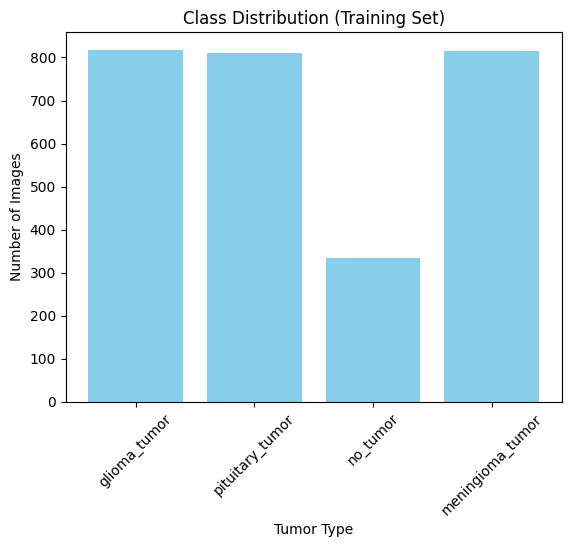

Training Set Class Counts: {'glioma_tumor': 818, 'pituitary_tumor': 810, 'no_tumor': 335, 'meningioma_tumor': 814}


In [24]:
import matplotlib.pyplot as plt

# Count images in each class (training set)
class_counts = {cls: len(os.listdir(os.path.join(train_dir, cls)))
                for cls in os.listdir(train_dir)}

plt.bar(class_counts.keys(), class_counts.values(), color="skyblue")
plt.title("Class Distribution (Training Set)")
plt.xlabel("Tumor Type")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()

print("Training Set Class Counts:", class_counts)

In [25]:
%matplotlib inline

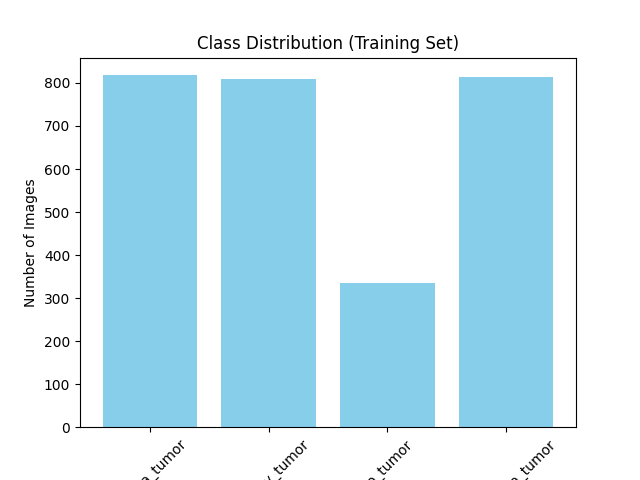

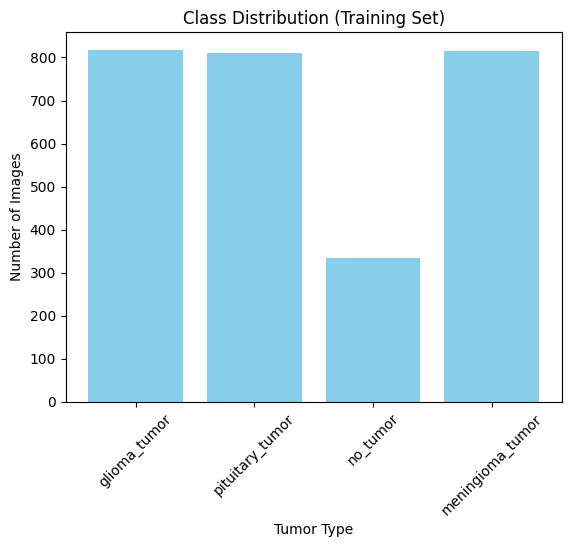

In [26]:
plt.bar(class_counts.keys(), class_counts.values(), color="skyblue")
plt.title("Class Distribution (Training Set)")
plt.xlabel("Tumor Type")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)

plt.savefig("class_dist.png")
from IPython.display import Image
Image("class_dist.png")

In [27]:
import cv2
import numpy as np

img_shapes = []

for cls in os.listdir(train_dir):
    cls_folder = os.path.join(train_dir, cls)
    for img_file in os.listdir(cls_folder)[:100]:  # sample 100 images
        img = cv2.imread(os.path.join(cls_folder, img_file))
        if img is not None:
            img_shapes.append(img.shape)

# Convert to numpy array
img_shapes = np.array(img_shapes)

print("Average Image Shape:", np.mean(img_shapes, axis=0))
print("Unique Shapes:", np.unique(img_shapes[:, :2], axis=0)[:10])


Average Image Shape: [224. 224.   3.]
Unique Shapes: [[224 224]]


In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import random
import os
import cv2

/tmp/ipython-input-460564068.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()), palette="viridis")


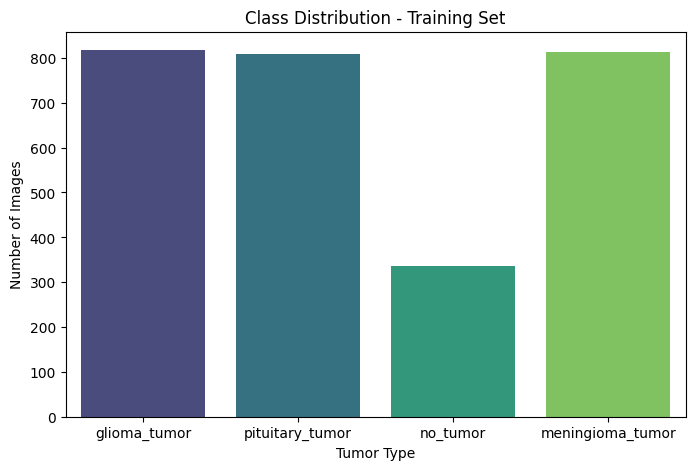

In [29]:
train_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in os.listdir(train_dir)}

plt.figure(figsize=(8,5))
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()), palette="viridis")
plt.title("Class Distribution - Training Set")
plt.xlabel("Tumor Type")
plt.ylabel("Number of Images")
plt.show()

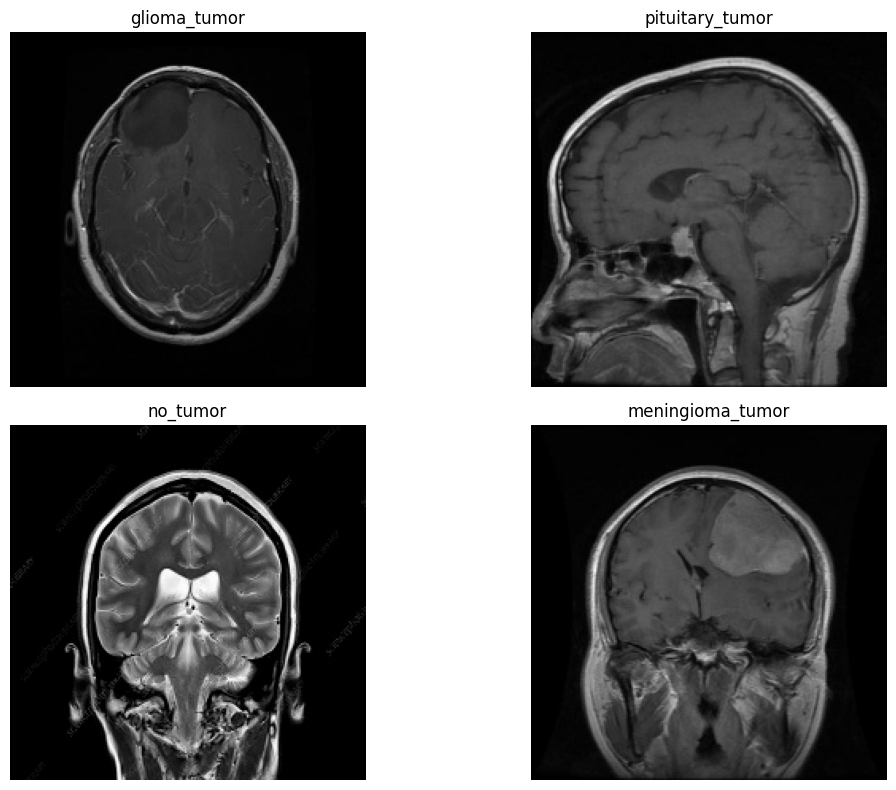

In [30]:
plt.figure(figsize=(12, 8))

for i, cls in enumerate(os.listdir(train_dir)):
    cls_folder = os.path.join(train_dir, cls)
    img_file = random.choice(os.listdir(cls_folder))
    img_path = os.path.join(cls_folder, img_file)

    img = mpimg.imread(img_path)
    plt.subplot(2, 2, i+1)
    plt.imshow(img, cmap="gray")
    plt.title(cls)
    plt.axis("off")

plt.tight_layout()
plt.show()

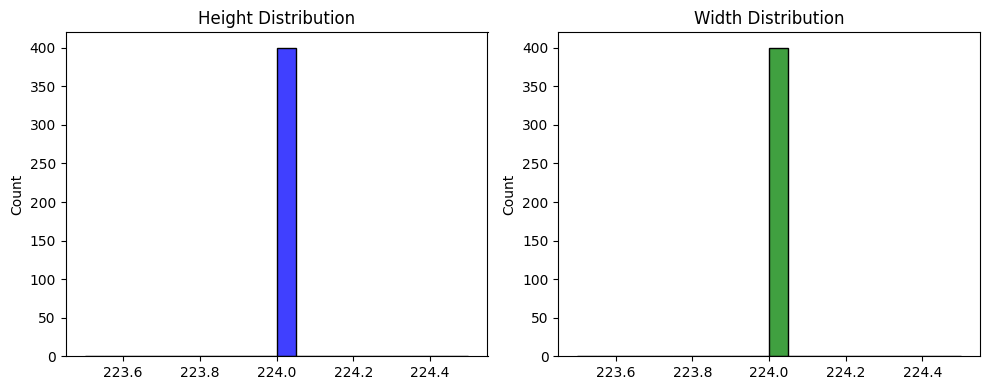

In [31]:
img_shapes = []
for cls in os.listdir(train_dir):
    cls_folder = os.path.join(train_dir, cls)
    for img_file in os.listdir(cls_folder)[:100]:  # sample 100 images per class
        img = cv2.imread(os.path.join(cls_folder, img_file))
        if img is not None:
            img_shapes.append(img.shape[:2])  # (height, width)

heights = [h for h, w in img_shapes]
widths = [w for h, w in img_shapes]

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(heights, bins=20, kde=False, color="blue")
plt.title("Height Distribution")

plt.subplot(1,2,2)
sns.histplot(widths, bins=20, kde=False, color="green")
plt.title("Width Distribution")

plt.tight_layout()
plt.show()

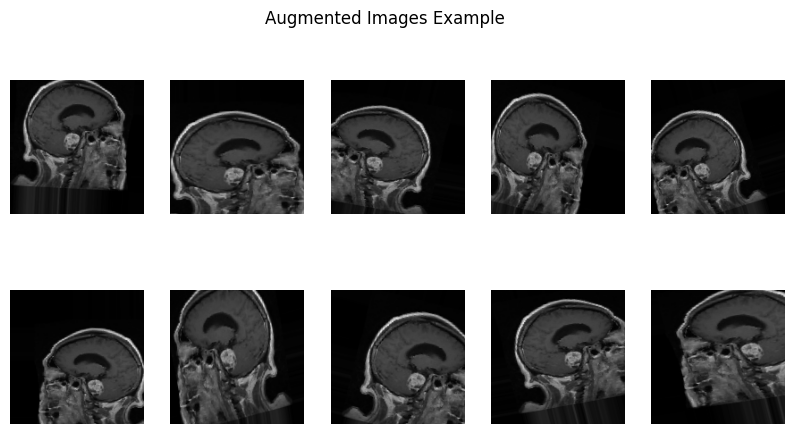

In [32]:
# 4. Data Augmentation Visualization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Example image
example_cls = random.choice(os.listdir(train_dir))
example_path = os.path.join(train_dir, example_cls, random.choice(os.listdir(os.path.join(train_dir, example_cls))))

img = load_img(example_path, target_size=(150,150))
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

datagen = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.15,
                             zoom_range=0.2,
                             horizontal_flip=True)

plt.figure(figsize=(10,5))
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(2, 5, i+1)
    plt.imshow(batch[0].astype('uint8'))
    plt.axis("off")
    i += 1
    if i == 10:  # show 10 augmented images
        break
plt.suptitle("Augmented Images Example")
plt.show()

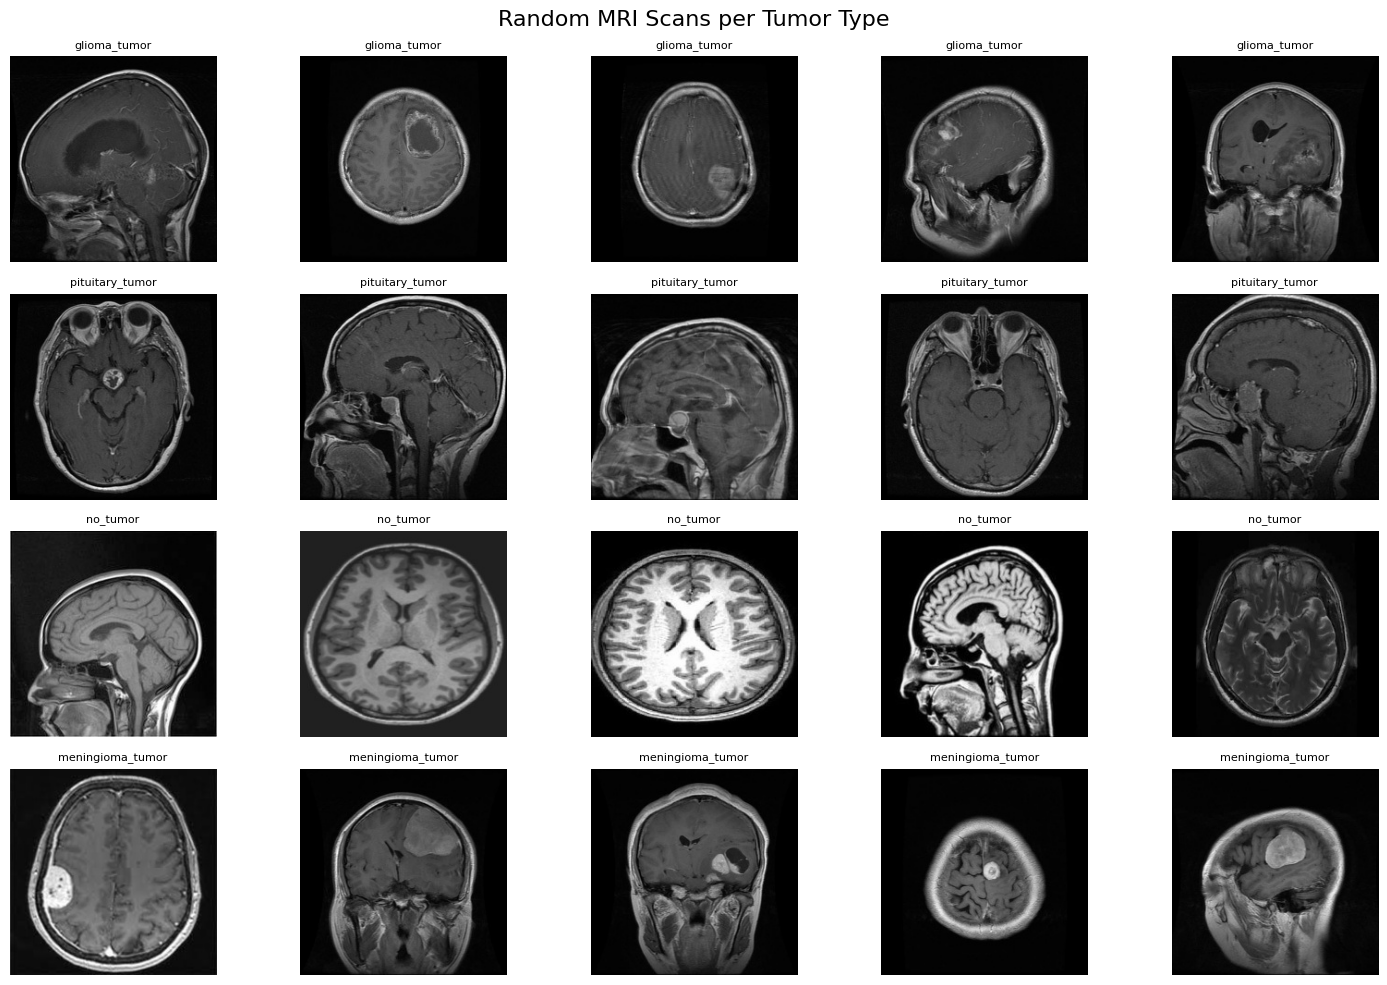

In [33]:
rows, cols = 4, 5  # 4 classes × 5 images each
plt.figure(figsize=(15, 10))

class_labels = os.listdir(train_dir)

for i, cls in enumerate(class_labels):
    cls_folder = os.path.join(train_dir, cls)
    sample_imgs = random.sample(os.listdir(cls_folder), 5)  # 5 random images per class

    for j, img_file in enumerate(sample_imgs):
        img_path = os.path.join(cls_folder, img_file)
        img = mpimg.imread(img_path)

        plt.subplot(rows, cols, i*5 + j + 1)
        plt.imshow(img, cmap="gray")
        plt.title(cls, fontsize=8)
        plt.axis("off")

plt.suptitle("Random MRI Scans per Tumor Type", fontsize=16)
plt.tight_layout()
plt.show()

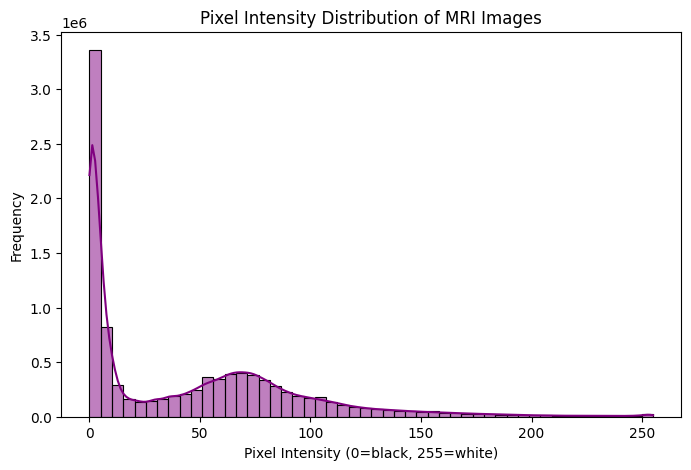

In [34]:
import numpy as np

all_pixels = []

for cls in os.listdir(train_dir):
    cls_folder = os.path.join(train_dir, cls)
    for img_file in os.listdir(cls_folder)[:50]:  # take sample
        img = cv2.imread(os.path.join(cls_folder, img_file), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            all_pixels.extend(img.flatten())

plt.figure(figsize=(8,5))
sns.histplot(all_pixels, bins=50, kde=True, color="purple")
plt.title("Pixel Intensity Distribution of MRI Images")
plt.xlabel("Pixel Intensity (0=black, 255=white)")
plt.ylabel("Frequency")
plt.show()

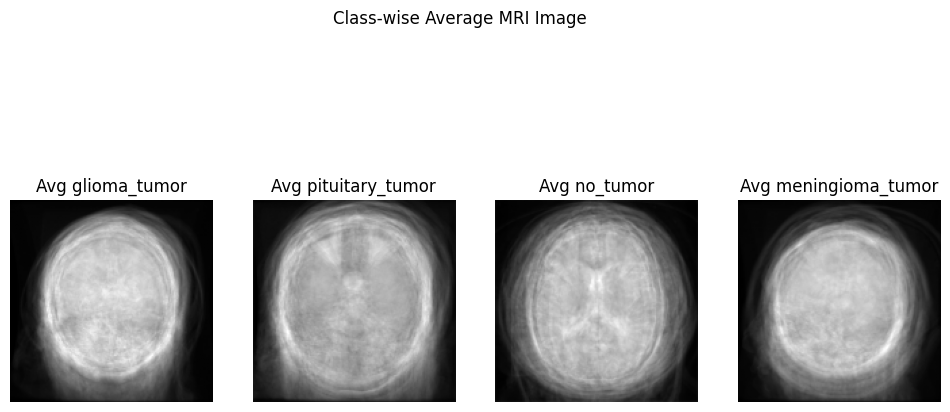

In [35]:
plt.figure(figsize=(12,6))

for i, cls in enumerate(os.listdir(train_dir)):
    cls_folder = os.path.join(train_dir, cls)

    imgs = []
    for img_file in os.listdir(cls_folder)[:50]:  # take 50 sample images
        img = cv2.imread(os.path.join(cls_folder, img_file), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (150,150))
            imgs.append(img)

    mean_img = np.mean(imgs, axis=0)

    plt.subplot(1, 4, i+1)
    plt.imshow(mean_img, cmap="gray")
    plt.title(f"Avg {cls}")
    plt.axis("off")

plt.suptitle("Class-wise Average MRI Image")
plt.show()

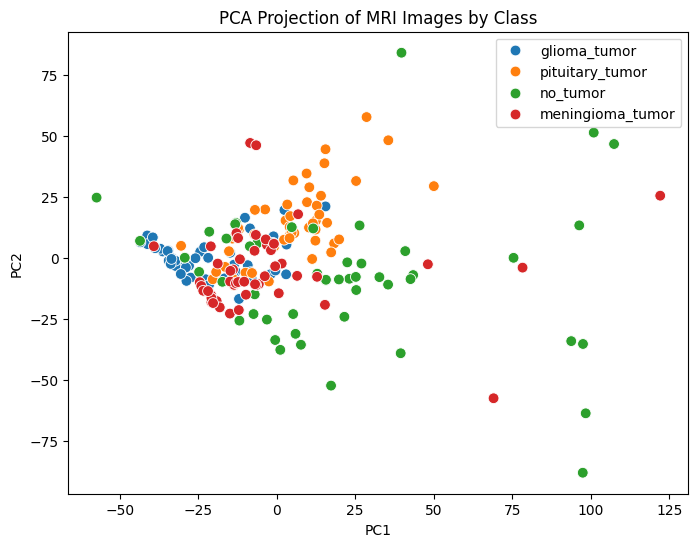

In [36]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

features = []
labels = []

for cls in os.listdir(train_dir):
    cls_folder = os.path.join(train_dir, cls)
    for img_file in os.listdir(cls_folder)[:50]:
        img = cv2.imread(os.path.join(cls_folder, img_file), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (64,64))
            features.append(img.flatten())
            labels.append(cls)

features = np.array(features)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=features_pca[:,0], y=features_pca[:,1], hue=labels, palette="tab10", s=60)
plt.title("PCA Projection of MRI Images by Class")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

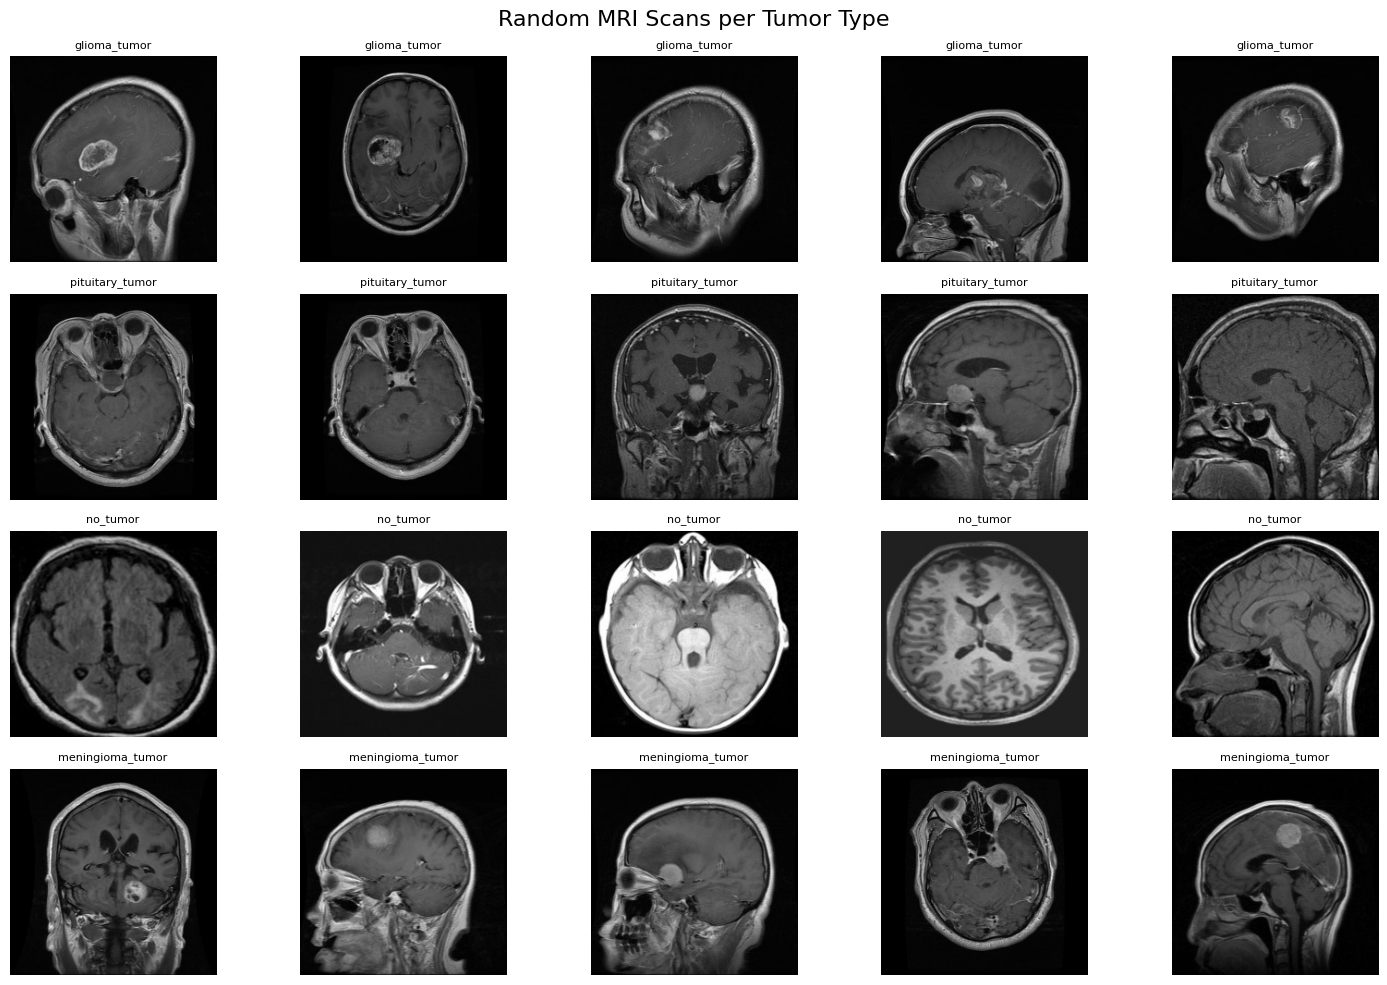

In [37]:
rows, cols = 4, 5  # 4 classes × 5 images each
plt.figure(figsize=(15, 10))

class_labels = os.listdir(train_dir)

for i, cls in enumerate(class_labels):
    cls_folder = os.path.join(train_dir, cls)
    sample_imgs = random.sample(os.listdir(cls_folder), 5)  # 5 random images per class

    for j, img_file in enumerate(sample_imgs):
        img_path = os.path.join(cls_folder, img_file)
        img = mpimg.imread(img_path)

        plt.subplot(rows, cols, i*5 + j + 1)
        plt.imshow(img, cmap="gray")
        plt.title(cls, fontsize=8)
        plt.axis("off")

plt.suptitle("Random MRI Scans per Tumor Type", fontsize=16)
plt.tight_layout()
plt.show()

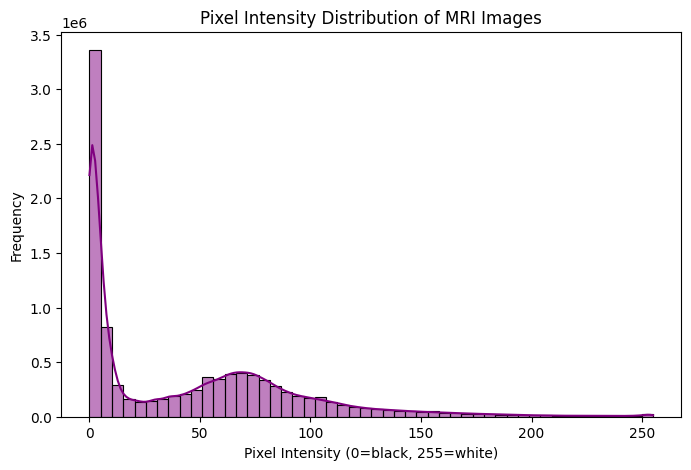

In [38]:
all_pixels = []

for cls in os.listdir(train_dir):
    cls_folder = os.path.join(train_dir, cls)
    for img_file in os.listdir(cls_folder)[:50]:  # take sample
        img = cv2.imread(os.path.join(cls_folder, img_file), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            all_pixels.extend(img.flatten())

plt.figure(figsize=(8,5))
sns.histplot(all_pixels, bins=50, kde=True, color="purple")
plt.title("Pixel Intensity Distribution of MRI Images")
plt.xlabel("Pixel Intensity (0=black, 255=white)")
plt.ylabel("Frequency")
plt.show()

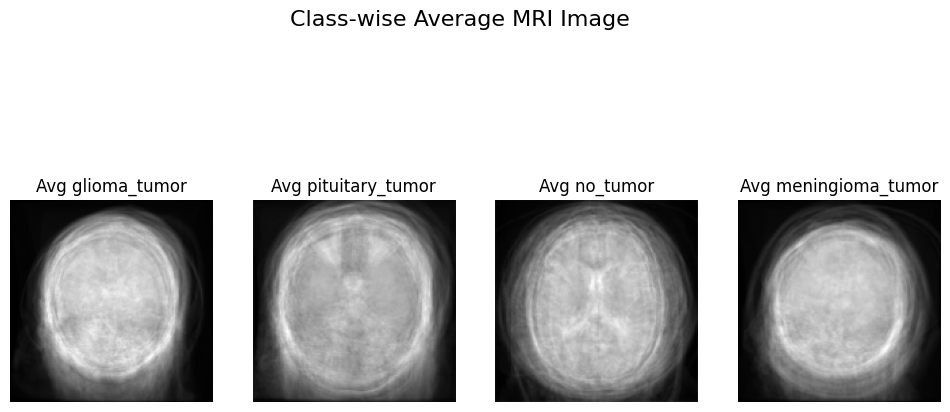

In [39]:
plt.figure(figsize=(12,6))

for i, cls in enumerate(os.listdir(train_dir)):
    cls_folder = os.path.join(train_dir, cls)

    imgs = []
    for img_file in os.listdir(cls_folder)[:50]:  # take 50 sample images
        img = cv2.imread(os.path.join(cls_folder, img_file), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (150,150))
            imgs.append(img)

    mean_img = np.mean(imgs, axis=0)

    plt.subplot(1, 4, i+1)
    plt.imshow(mean_img, cmap="gray")
    plt.title(f"Avg {cls}")
    plt.axis("off")

plt.suptitle("Class-wise Average MRI Image", fontsize=16)
plt.show()

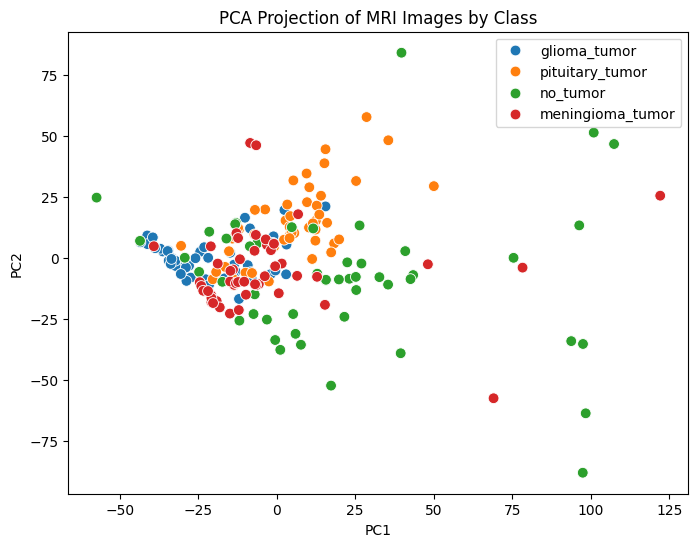

In [40]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

features = []
labels = []

for cls in os.listdir(train_dir):
    cls_folder = os.path.join(train_dir, cls)
    for img_file in os.listdir(cls_folder)[:50]:  # take 50 sample images
        img = cv2.imread(os.path.join(cls_folder, img_file), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (64,64))
            features.append(img.flatten())
            labels.append(cls)

features = np.array(features)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=features_pca[:,0], y=features_pca[:,1], hue=labels, palette="tab10", s=60)
plt.title("PCA Projection of MRI Images by Class")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

In [41]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define ImageDataGenerator with augmentations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

# Training set with augmentation
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode="categorical",
    subset="training"
)

# Validation set (no augmentation, just rescaling)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

val_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode="categorical",
    subset="validation"
)

Found 2223 images belonging to 4 classes.
Found 554 images belonging to 4 classes.


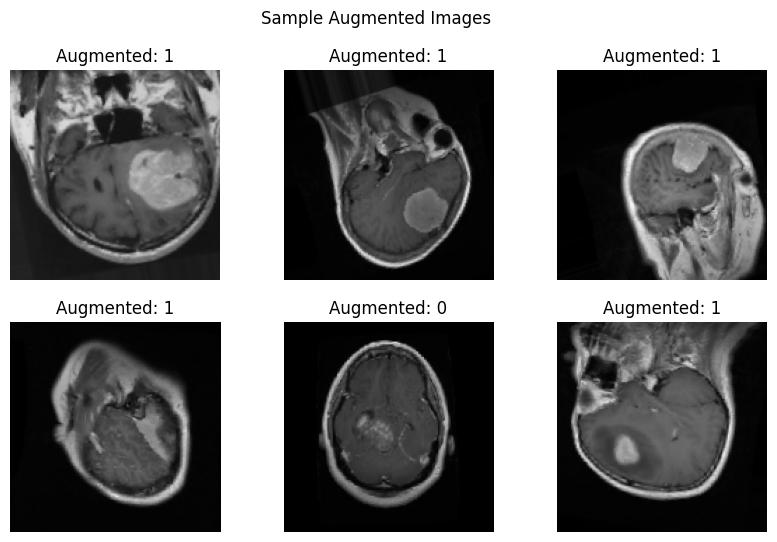

In [42]:
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(10,6))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(x_batch[i])
    plt.title(f"Augmented: {np.argmax(y_batch[i])}")
    plt.axis("off")
plt.suptitle("Sample Augmented Images")
plt.show()

In [43]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

# Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,             # normalization
    rotation_range=20,          # rotate images
    width_shift_range=0.1,      # shift width
    height_shift_range=0.1,     # shift height
    zoom_range=0.1,             # zoom in/out
    horizontal_flip=True,       # flip horizontally
    vertical_flip=True,         # flip vertically
    validation_split=0.2        # split training/validation
)

# Training set
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

# Validation set (no augmentation except rescaling)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

val_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)

# Test set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 2223 images belonging to 4 classes.
Found 554 images belonging to 4 classes.
Found 17 images belonging to 1 classes.


In [44]:
print("Class indices:", train_generator.class_indices)
print("Number of training samples:", train_generator.samples)
print("Number of validation samples:", val_generator.samples)
print("Number of test samples:", test_generator.samples)

Class indices: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
Number of training samples: 2223
Number of validation samples: 554
Number of test samples: 17


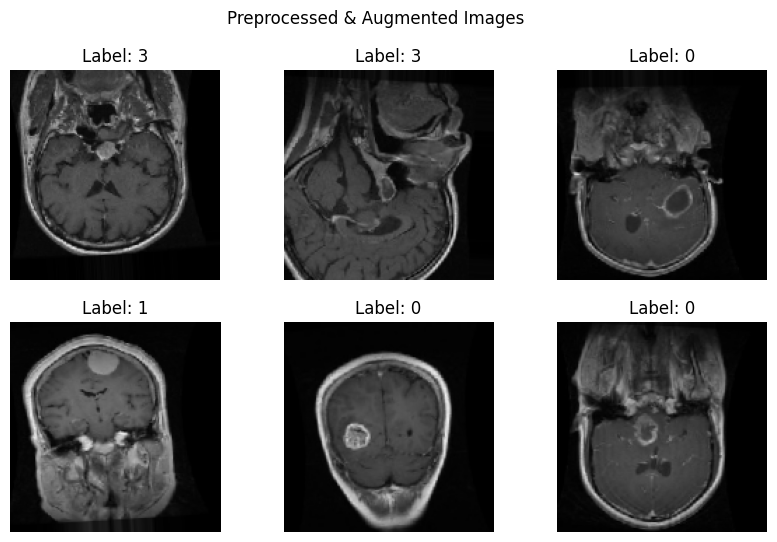

In [45]:
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(10,6))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(x_batch[i])
    plt.title(f"Label: {np.argmax(y_batch[i])}")
    plt.axis("off")
plt.suptitle("Preprocessed & Augmented Images")
plt.show()

In [46]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2,2)),
    BatchNormalization(),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    BatchNormalization(),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

# Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_cnn_model.h5", monitor='val_accuracy', save_best_only=True)

# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop, checkpoint]
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4281 - loss: 3.4783

70/70 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.4280 - loss: 3.4618 - val_accuracy: 0.2924 - val_loss: 2.4772
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3845 - loss: 1.3761

70/70 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.3847 - loss: 1.3761 - val_accuracy: 0.3285 - val_loss: 1.8409
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.4024 - loss: 1.3053 - val_accuracy: 0.2834 - val_loss: 2.9031
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.4489 - loss: 1.1884 - val_accuracy: 0.2924 - val_loss: 3.1851
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.4623 - loss: 1.1788 - val_accuracy: 0.1444 - val_loss: 2.6176
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4722 - loss: 1.1827

70/70 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.4720 - loss: 1.1830 - val_accuracy: 0.3556 - val_loss: 1.2065
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.4721 - loss: 1.2024 - val_accuracy: 0.2924 - val_loss: 2.0081
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4471 - loss: 1.2105

70/70 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.4474 - loss: 1.2098 - val_accuracy: 0.4079 - val_loss: 1.5766
Epoch 9/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5041 - loss: 1.1746

70/70 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.5041 - loss: 1.1740 - val_accuracy: 0.4224 - val_loss: 1.1885
Epoch 10/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5000 - loss: 1.1317

70/70 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.5001 - loss: 1.1313 - val_accuracy: 0.4928 - val_loss: 1.2259
Epoch 11/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.5191 - loss: 1.0804 - val_accuracy: 0.4783 - val_loss: 1.8238
Epoch 12/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.5486 - loss: 0.9915 - val_accuracy: 0.3953 - val_loss: 2.2920
Epoch 13/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.5334 - loss: 1.0628 - val_accuracy: 0.4386 - val_loss: 1.8557
Epoch 14/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.5460 - loss: 1.0730 - val_accuracy: 0.3556 - val_loss: 1.5424


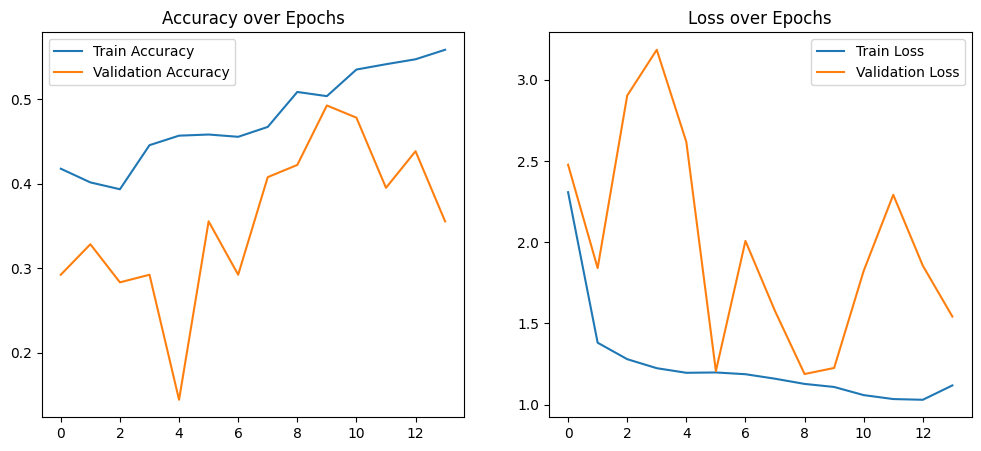

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy over Epochs")

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss over Epochs")

plt.show()

In [48]:
print("Training classes:", train_generator.class_indices)
print("Validation classes:", val_generator.class_indices)
print("Testing classes:", test_generator.class_indices)

Training classes: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
Validation classes: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
Testing classes: {'pituitary_tumor': 0}


In [49]:
import os

test_path = test_generator.directory
for class_name in os.listdir(test_path):
    class_folder = os.path.join(test_path, class_name)
    if os.path.isdir(class_folder):
        print(f"{class_name}: {len(os.listdir(class_folder))} images")

pituitary_tumor: 17 images


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


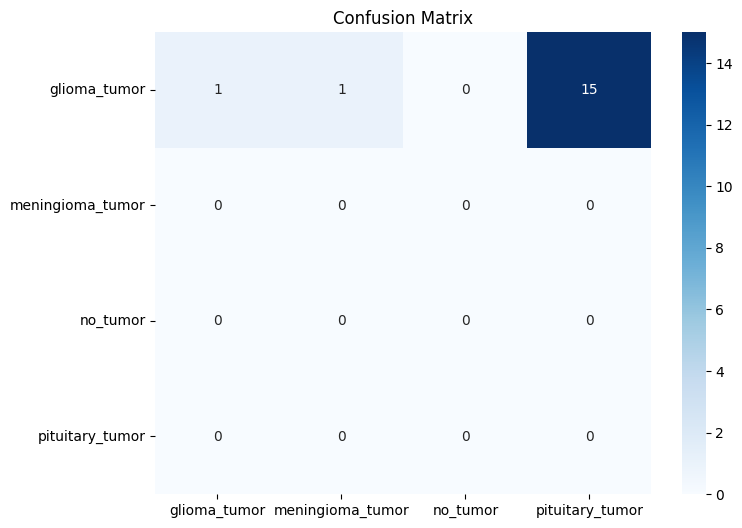

Classification Report:

                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.06      0.11        17
meningioma_tumor       0.00      0.00      0.00         0
        no_tumor       0.00      0.00      0.00         0
 pituitary_tumor       0.00      0.00      0.00         0

        accuracy                           0.06        17
       macro avg       0.25      0.01      0.03        17
    weighted avg       1.00      0.06      0.11        17



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

In [50]:
# Safe extraction of labels
class_labels = list(train_generator.class_indices.keys())  # use train classes instead of test

y_pred = model.predict(test_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes, labels=range(len(class_labels)))
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_labels,
            yticklabels=class_labels,
            cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, labels=range(len(class_labels)), target_names=class_labels))

In [51]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [52]:
from tensorflow.keras import models, layers

In [53]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers

# Load VGG16 as base model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))

# Freeze pretrained layers
for layer in base_model.layers:
    layer.trainable = False

# Build final model
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')   # Change '3' if you have more classes
])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [54]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import models, layers

base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [55]:
for layer in base_model.layers[-30:]:
    layer.trainable = True

In [56]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6)

In [57]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=0.5),
    A.GaussianBlur(blur_limit=3, p=0.3),
    A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
    ToTensorV2()
])

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [58]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

In [59]:
# Unfreeze the base model
base_model.trainable = True

# Recompile
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [60]:
# Freeze most of the base model, unfreeze last 20 layers
for layer in base_model.layers[:-20]:
    layer.trainable = False
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Recompile
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [61]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_layer_3
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activa

In [62]:
import joblib

# Assuming your trained model variable is called `model`
joblib.dump(model, "model.pkl")
print("✅ Model saved as model.pkl")

✅ Model saved as model.pkl


In [63]:
import joblib

# Load model
model = joblib.load("model.pkl")

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 48 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [64]:
import os
import joblib

if os.path.exists("model.pkl"):
    model = joblib.load("model.pkl")
    print("✅ Loaded existing model")
else:
    # Train your model here
    model.fit(X_train, y_train)
    joblib.dump(model, "model.pkl")
    print("✅ New model trained and saved")

✅ Loaded existing model


In [66]:
!pip install fastapi uvicorn pyngrok nest_asyncio

In [71]:
IMG_SIZE = 224   # EfficientNet needs 224

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    "/content/brain_tumor_dataset/Training",
    target_size=(IMG_SIZE, IMG_SIZE),  # ✅ set to 224
    batch_size=32,
    class_mode="categorical",
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    "/content/brain_tumor_dataset/Training",
    target_size=(IMG_SIZE, IMG_SIZE),  # ✅ set to 224
    batch_size=32,
    class_mode="categorical",
    subset="validation"
)

Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.


In [79]:
ls

best_cnn_model.h5     brain_tumor_dataset/  drive/     sample_data/
brain_tumor_cleaned/  class_dist.png        model.pkl


In [83]:
mv best_cnn_model.h5 brain_tumor_model.h5

In [85]:
!python app.py

python3: can't open file '/content/app.py': [Errno 2] No such file or directory


In [87]:
!pip install flask-ngrok

In [89]:
!ls -lh /content

total 73M
-rw-r--r-- 1 root root 1.4K Aug 22 05:26 app.py
drwxr-xr-x 4 root root 4.0K Aug 22 04:45 brain_tumor_cleaned
drwxr-xr-x 4 root root 4.0K Aug 22 04:45 brain_tumor_dataset
-rw-r--r-- 1 root root  56M Aug 22 05:08 brain_tumor_model.h5
-rw-r--r-- 1 root root  23K Aug 22 04:45 class_dist.png
drwx------ 5 root root 4.0K Aug 22 04:37 drive
-rw-r--r-- 1 root root  18M Aug 22 05:16 model.pkl
drwxr-xr-x 2 root root 4.0K Aug 22 05:28 __pycache__
drwxr-xr-x 1 root root 4.0K Aug 20 21:31 sample_data


In [103]:
MODEL_PATH = "/content/brain_tumor_model.h5"

In [104]:
import tensorflow as tf

MODEL_PATH = "/content/brain_tumor_model.h5"
model = tf.keras.models.load_model(MODEL_PATH)

In [100]:
import tensorflow as tf

# Load your trained CNN model
model = tf.keras.models.load_model("brain_tumor_model.h5", compile=False)

In [99]:
import os
print(os.listdir())

['.config', 'brain_tumor_model.h5', 'brain_tumor_dataset', 'drive', 'class_dist.png', '__pycache__', 'brain_tumor_cleaned', 'app.py', 'model.pkl', 'sample_data']


In [111]:
ModelCheckpoint("best_cnn_model.h5", monitor='val_accuracy', save_best_only=True)

In [113]:
!pip install pyngrok

In [114]:
!ngrok config add-authtoken 30dnccOrwJ9hob64KP60KQ9mQFf_5hE67WwFWhJ9bSYeVqgVH

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [123]:
!pip install pyngrok --quiet

In [124]:
import os, glob
print("Here:", os.listdir("/content"))
print("Model exists:", os.path.exists("/content/brain_tumor_model.h5"))

Here: ['.config', 'uploaded_image.jpg', 'brain_tumor_model.h5', 'brain_tumor_dataset', 'drive', 'class_dist.png', '__pycache__', 'brain_tumor_cleaned', 'app.py', 'model.pkl', 'sample_data']
Model exists: True


In [138]:
!pip install tensorflow keras albumentations

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

SEED = 42
BATCH_SIZE = 32
IMG_SIZE = (224, 224)   # EfficientNet expects 224x224
EPOCHS = 20
DATA_DIR = "/content/brain_tumor_dataset"

In [139]:
train_dir = os.path.join(DATA_DIR, "Training")
test_dir  = os.path.join(DATA_DIR, "Testing")

In [141]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

In [142]:
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode="categorical", subset="training", seed=SEED
)

val_gen = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode="categorical", subset="validation", seed=SEED
)

test_gen = test_datagen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode="categorical", shuffle=False
)

print("Class indices:", train_gen.class_indices)


Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.
Found 35 images belonging to 1 classes.
Class indices: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


In [143]:
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=IMG_SIZE+(3,))
base_model.trainable = False  # freeze base model for transfer learning

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(train_gen.num_classes, activation="softmax")
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,378,535 (16.70 MB)

 Trainable params: 328,964 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [144]:
base_model.trainable = True
for layer in base_model.layers[:-30]:  # keep most layers frozen
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

history_finetune = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 321s 4s/step - accuracy: 0.2380 - loss: 1.4581 - val_accuracy: 0.2862 - val_loss: 1.3961
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 292s 4s/step - accuracy: 0.2784 - loss: 1.4412 - val_accuracy: 0.2862 - val_loss: 1.4016
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 263s 4s/step - accuracy: 0.2606 - loss: 1.4341 - val_accuracy: 0.1379 - val_loss: 1.4153
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 349s 4s/step - accuracy: 0.2465 - loss: 1.4306 - val_accuracy: 0.1379 - val_loss: 1.4412
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 253s 4s/step - accuracy: 0.2320 - loss: 1.4430 - val_accuracy: 0.1379 - val_loss: 1.4729
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 291s 4s/step - accuracy: 0.2337 - loss: 1.4291 - val_accuracy: 0.1379 - val_loss: 1.4781
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 271s 4s/step - accuracy: 0.2386 - loss: 1.4483 - val_accuracy: 0.1379 - val_loss: 1.4613
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 249s 3s/step - accuracy: 0.2214 - loss: 1.4293 - val_accuracy: 0.1379 - v

In [145]:
loss, acc = model.evaluate(test_gen)
print(f"✅ Test Accuracy: {acc*100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 170ms/step - accuracy: 0.0000e+00 - loss: 5.6216
✅ Test Accuracy: 0.00%


In [146]:
model.save("efficientnet_brain_tumor.h5")
print("Model saved as efficientnet_brain_tumor.h5")

Model saved as efficientnet_brain_tumor.h5


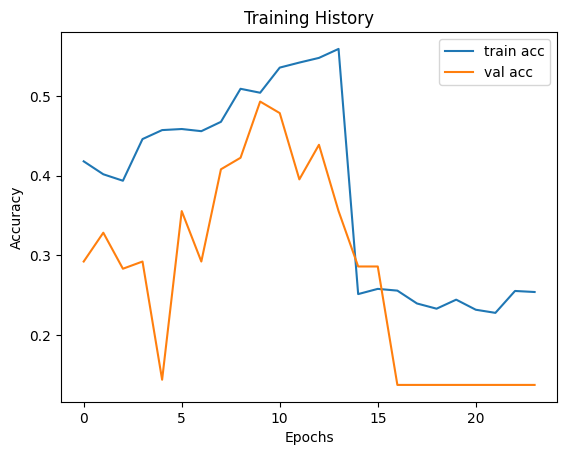

In [147]:
def plot_history(history, title="Training History"):
    plt.plot(history.history["accuracy"] + history_finetune.history["accuracy"], label="train acc")
    plt.plot(history.history["val_accuracy"] + history_finetune.history["val_accuracy"], label="val acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.legend()
    plt.show()

plot_history(history)

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step
Class labels: ['pituitary_tumor']
Classification Report:
                  precision    recall  f1-score   support

pituitary_tumor       0.00      0.00      0.00      35.0

      micro avg       0.00      0.00      0.00      35.0
      macro avg       0.00      0.00      0.00      35.0
   weighted avg       0.00      0.00      0.00      35.0



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.p

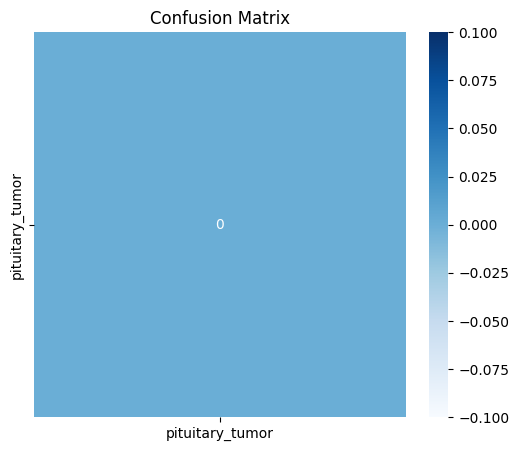

In [149]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd

# True and predicted labels
y_true = test_gen.classes
y_pred = np.argmax(model.predict(test_gen), axis=1)

# Get class labels in correct order
class_labels = list(test_gen.class_indices.keys())
print("Class labels:", class_labels)

# Classification report
print("Classification Report:\n", classification_report(y_true, y_pred, labels=np.arange(len(class_labels)), target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_labels)))
df_cm = pd.DataFrame(cm, index=class_labels, columns=class_labels)

plt.figure(figsize=(6,5))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


In [150]:
HTML_FORM = """
<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>Brain Tumor Classifier</title>
  <link href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.2/dist/css/bootstrap.min.css" rel="stylesheet">
  <style>
    body { background: #f8f9fa; }
    .card { max-width: 600px; margin: auto; margin-top: 40px; box-shadow: 0 4px 15px rgba(0,0,0,0.1); }
    .upload-box {
      border: 2px dashed #6c757d; padding: 20px; text-align: center;
      border-radius: 10px; cursor: pointer; background: #fff;
    }
    .upload-box:hover { background: #f1f1f1; }
    img.preview { max-width: 100%; border-radius: 10px; margin-top: 15px; }
    .progress { height: 24px; }
  </style>
</head>
<body>
<div class="container">
  <div class="card p-4">
    <h2 class="text-center">🧠 Brain Tumor Classification</h2>
    <p class="text-muted text-center">
      Model input size: {{ img_size }}, Classes: {{ class_names }}
    </p>

    <form method="POST" enctype="multipart/form-data">
      <label class="upload-box" id="uploadBox">
        <input type="file" name="file" accept="image/*" hidden onchange="previewFile(this)">
        <p class="mb-0">📤 Click or Drag & Drop MRI image here</p>
      </label>
      <div class="text-center">
        <img id="previewImg" class="preview" src="" alt="">
      </div>
      <div class="text-center mt-3">
        <button type="submit" class="btn btn-primary btn-lg">🔍 Predict</button>
      </div>
    </form>

    {% if error %}
      <div class="alert alert-danger mt-3">
        ⚠ {{ error }}
        <pre style="font-size:12px">{{ details }}</pre>
      </div>
    {% endif %}

    {% if pred_label %}
      <div class="alert alert-success mt-3 text-center">
        <h4>Prediction: {{ pred_label }}</h4>
        <p>Confidence: {{ (confidence*100)|round(2) }}%</p>
      </div>

      <h5>Class Probabilities:</h5>
      {% for row in probs %}
        <label>{{ row[0] }}</label>
        <div class="progress mb-2">
          <div class="progress-bar
                      {% if row[0]==pred_label %} bg-success {% else %} bg-secondary {% endif %}"
               role="progressbar" style="width: {{ (row[1]*100)|round(2) }}%">
            {{ (row[1]*100)|round(1) }}%
          </div>
        </div>
      {% endfor %}
    {% endif %}
  </div>
</div>

<script>
  function previewFile(input){
    let file = input.files[0];
    if(file){
      let reader = new FileReader();
      reader.onload = function(e){
        document.getElementById('previewImg').src = e.target.result;
      }
      reader.readAsDataURL(file);
    }
  }
</script>
</body>
</html>
"""


In [151]:
print("Model input shape:", model.input_shape)

Model input shape: (None, 224, 224, 3)


In [152]:
%%writefile app.py
import os
import numpy as np
from flask import Flask, request, render_template_string
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from pyngrok import ngrok
import traceback

# ---------- CONFIG ----------
MODEL_PATH = "brain_tumor_model.h5"
ALLOWED_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}

# If you trained multi-class and know your class order, put it here.
KNOWN_CLASS_NAMES = ["Glioma", "Meningioma", "Pituitary", "No Tumor"]  # adjust if needed
# ---------------------------

app = Flask(__name__)
os.makedirs("uploads", exist_ok=True)

# Load model
print("Loading model from:", MODEL_PATH)
model = tf.keras.models.load_model(MODEL_PATH, compile=False)
print("Model loaded.")

# Detect input size
try:
    IMG_SIZE = model.input_shape[1:3]  # e.g. (150,150)
except Exception:
    IMG_SIZE = (224,224)
print("Using input size:", IMG_SIZE)

# Detect number of outputs
try:
    out_shape = model.output_shape
    if isinstance(out_shape, list):
        out_dim = out_shape[0][-1]
    else:
        out_dim = out_shape[-1]
except Exception as e:
    print("Could not infer output shape; defaulting to binary:", e)
    out_dim = 1

is_binary = (out_dim == 1)

# Build class names
if is_binary:
    CLASS_NAMES = ["No Tumor", "Tumor"]
else:
    if len(KNOWN_CLASS_NAMES) == out_dim:
        CLASS_NAMES = KNOWN_CLASS_NAMES
    else:
        CLASS_NAMES = [f"Class_{i}" for i in range(out_dim)]

print("Detected output dimension:", out_dim)
print("Using class names:", CLASS_NAMES)

# ---------- HTML FORM ----------
HTML_FORM = """
<!doctype html>
<html>
<head>
  <title>Brain Tumor Classification</title>
</head>
<body>
  <h1>🧠 Brain Tumor Classification</h1>
  <p>Model input size: {{ img_size }}, output dim: {{ out_dim }}, classes: {{ class_names }}</p>
  <form method="POST" enctype="multipart/form-data">
    <input type="file" name="file" accept="image/*" required />
    <button type="submit">Predict</button>
  </form>

  {% if error %}
    <p style="color:red;">⚠ {{ error }}</p>
    <pre>{{ details }}</pre>
  {% endif %}

  {% if pred_label %}
    <h2>Prediction: {{ pred_label }} ({{ (confidence*100)|round(2) }}%)</h2>
  {% endif %}

  {% if probs %}
    <h3>Class probabilities:</h3>
    <ul>
      {% for row in probs %}
        <li>{{ row[0] }}: {{ (row[1]*100)|round(2) }}%</li>
      {% endfor %}
    </ul>
  {% endif %}
</body>
</html>
"""

# ---------- HELPERS ----------
def allowed_file(filename: str) -> bool:
    ext = os.path.splitext(filename)[1].lower()
    return ext in ALLOWED_EXTS

def preprocess_img(path: str, size=(224,224)) -> np.ndarray:
    img = image.load_img(path, target_size=size, color_mode="rgb")
    arr = image.img_to_array(img) / 255.0
    return np.expand_dims(arr, axis=0)

# ---------- ROUTES ----------
@app.route("/", methods=["GET", "POST"])
def index():
    if request.method == "POST":
        try:
            if "file" not in request.files:
                return render_template_string(HTML_FORM,
                    img_size=IMG_SIZE, out_dim=out_dim, class_names=CLASS_NAMES,
                    error="No file part in request.", details=None)

            file = request.files["file"]
            if file.filename == "":
                return render_template_string(HTML_FORM,
                    img_size=IMG_SIZE, out_dim=out_dim, class_names=CLASS_NAMES,
                    error="No file selected.", details=None)

            if not allowed_file(file.filename):
                return render_template_string(HTML_FORM,
                    img_size=IMG_SIZE, out_dim=out_dim, class_names=CLASS_NAMES,
                    error=f"Unsupported file type. Allowed: {sorted(ALLOWED_EXTS)}",
                    details=None)

            save_path = os.path.join("uploads", file.filename)
            file.save(save_path)

            x = preprocess_img(save_path, IMG_SIZE)
            preds = model.predict(x)

            if is_binary:
                p = float(preds[0][0])
                label_idx = 1 if p >= 0.5 else 0
                confidence = p if label_idx == 1 else (1.0 - p)
                pred_label = CLASS_NAMES[label_idx]
                probs_sorted = [(CLASS_NAMES[0], 1.0 - p), (CLASS_NAMES[1], p)]
            else:
                probs = preds[0].astype(float)
                label_idx = int(np.argmax(probs))
                confidence = float(probs[label_idx])
                pred_label = CLASS_NAMES[label_idx]
                probs_sorted = sorted(zip(CLASS_NAMES, probs), key=lambda t: t[1], reverse=True)

            return render_template_string(HTML_FORM,
                img_size=IMG_SIZE, out_dim=out_dim, class_names=CLASS_NAMES,
                pred_label=pred_label, confidence=confidence, probs=probs_sorted,
                error=None, details=None)

        except Exception as e:
            traceback.print_exc()
            return render_template_string(HTML_FORM,
                img_size=IMG_SIZE, out_dim=out_dim, class_names=CLASS_NAMES,
                error=f"Internal error: {str(e)}", details=traceback.format_exc())

    return render_template_string(HTML_FORM,
        img_size=IMG_SIZE, out_dim=out_dim, class_names=CLASS_NAMES,
        error=None, details=None, pred_label=None, confidence=None, probs=None)

@app.route("/healthz")
def healthz():
    return {"status": "ok", "out_dim": out_dim, "classes": CLASS_NAMES}, 200

if __name__ == "__main__":
    try:
        for t in ngrok.get_tunnels():
            if t.config.get("addr", "").endswith(":5000"):
                ngrok.disconnect(t.public_url)
    except Exception:
        pass

    public_url = ngrok.connect(5000).public_url
    print("🚀 Public URL:", public_url)
    app.run(host="0.0.0.0", port=5000, use_reloader=False)


Overwriting app.py


In [156]:
!pip install gradio tensorflow pillow

import gradio as gr
import numpy as np
import tensorflow as tf
from PIL import Image

MODEL_PATH = "efficientnet_brain_tumor.h5"
IMG_SIZE = (224, 224)
CLASS_NAMES = ["Glioma", "Meningioma", "No Tumor", "Pituitary"]

model = tf.keras.models.load_model(MODEL_PATH)

def predict(image):
    image = image.resize(IMG_SIZE)
    x = np.expand_dims(np.array(image)/255.0, axis=0)
    preds = model.predict(x)
    return {CLASS_NAMES[i]: float(preds[0][i]) for i in range(len(CLASS_NAMES))}

gr.Interface(fn=predict,
             inputs=gr.Image(type="pil"),
             outputs=gr.Label(num_top_classes=4),
             title="🧠 Brain Tumor Classifier").launch()


ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-1' coro=<Server.serve() done, defined at /usr/local/lib/python3.12/dist-packages/uvicorn/server.py:69> exception=KeyboardInterrupt()>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/main.py", line 580, in run
    server.run()
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/server.py", line 67, in run
    return asyncio.run(self.serve(sockets=sockets))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/nest_asyncio.py", line 30, in run
    return loop.run_until_complete(task)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/nest_asyncio.py", line 92, in run_until_complete
    self._run_once()
  File "/usr/local/lib/python3.12/dist-packages/nest_asyncio.py", line 133, in _run_once
    handle._run()
  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run
    se

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ceeb00986cbc86acf5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [157]:
!python app.py

2025-08-22 07:27:52.100797: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755847672.163493   42802 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755847672.197003   42802 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755847672.240229   42802 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755847672.240295   42802 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755847672.240306   42802 computation_placer.cc:177] computation placer alr